## Northwestern Intercampus Shuttle

This Jupyter Notebook shows information about how well the Northwestern Intercampus Shuttle matches its schedule.

Let's start by importing all the libraries we need

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime as dt
import time
import random
%matplotlib inline

Now we need some functions to read in the data we've stored in .csv files. First, something to read the bus schedule spreadsheet, then something to read the spreadsheet of data we've collected of recorded stops.

In [2]:
def read_schedule(filename):
    """
    Reads a file containing the schedule of a shuttle
    File top rows contain the name of the bus stop
        
    """
    sched = dict()
    with open(filename, 'r') as fin:
        csvreader = csv.reader(fin, delimiter=',')
        header = next(csvreader)
        for line in csvreader:
            for i in range( len( line ) ):
                t = float(line[i]) * 24
                sched.setdefault(header[i], []).append(t)
        
    return sched

def read_bus_data(filename):
    """
    Reads information about which bus on which route stopped at which stop at what time
    """
    stops = dict()
    
    with open(filename, 'r') as fin:
        csvreader = csv.reader(fin)
        header = next(csvreader)
        stop_name_index = header.index('Stop Name')
        stop_time_index = header.index('Seconds after midnight')
        for line in csvreader:
            t = float(line[stop_time_index]) / 3600
            stops.setdefault(line[stop_name_index], []).append(t)
    
    return stops

Now we need something that will make a plot of all the times we've recorded vs what the schedule says.

In [3]:
def plot_stop_histogram(sched, stops, stop, start=6, end=24):
    """Plots a histogram of stopped times using the schedule data"""
    
    if stop not in sched or stop not in stops:
        raise KeyError('The stop you provided is not in the schedule or the data.')
    scheduled = sched[stop]
    stopped = stops[stop]
    start_time = time.time()
    with plt.style.context('bmh'):
               
        fig = plt.figure( figsize = (20, 4.5) )
        ax = fig.add_subplot(1,1,1)
        font_size = 15
        minute_bins = [x/60.0 for x in range(6 * 60, 24*60)]
 
        ax.hist(stopped, bins=minute_bins)

       

        ax.set_xlabel('Time', fontsize = 1.6 * font_size)
        ax.set_ylabel('Count', fontsize = 1.6 * font_size)
         
        hours = [x for x in range(0, 24)]    
        hour_labels = map(lambda x: str(x) + ':00', hours)
        
        plt.xticks(hours, hour_labels, rotation=45)
        plt.xlim(start, end)
        plt.tick_params(labelsize=20)
        plt.title(stop)
        
        for stime in scheduled:
            plt.axvline(stime)
        
        plt.show()
        end_time = time.time()

    print(end_time-start_time, 's to run')

Now, putting it all together

In [4]:
schedule = read_schedule('evanstontochicago.csv')
stop_data = read_bus_data('intercampus_data.csv')

And using a nice Seaborn library to make it pretty...

In [5]:
import seaborn as sbs

def stop_order(d):
    """Returns sorted list of strings by the first element in the list they map to"""
    stops = []
    
    for stop, times in d.items():
        stops.append((times[0], stop))
        
    stops.sort()
    
    return [s for t, s in stops]    
    
def generate_2d_stop_data(stopped, order, schedules, window):
    """Generates a colormap-compatible 2d array with the stops in order"""
    minutes_in_a_day = 60*24
    minute_bins = [x/60.0 for x in range(minutes_in_a_day)]
    data = np.zeros( shape = (len(order), len(minute_bins)-1) )

        # Go through the schedule data in the histogram and multiply by -1 if the recorded
    # stop time is outside of the specified window around a scheduled time.
    for i in range(len(order)):
        row, bins = np.histogram(stopped[order[i]], bins=minute_bins)
        schedule_row, schedule_bins = np.histogram(schedules[order[i]], bins=minute_bins)
        data[i, :] = -1 * row
        nonzero_indices = np.nonzero(schedule_row)
        for index in nonzero_indices[0]:
            for good_index in range(index-1, index + window):
                data[i, good_index] = -1 * data[i, good_index]


    return data
        
    
    
def bus_heatmap(sched, stops, start=6, end=23, window=5):
    """Plots a colormap of stopped times using the schedule data"""
   
    order = stop_order(sched)
    hm_data = generate_2d_stop_data(stops, order, sched, window + 1)
    hours = []
    for x in range(0, 24):
        hours.append(str(x) + ':00')
        hours.extend(['']*59)
    
    start_time = time.time()


    fig = plt.figure( figsize = (20, 15) )
    ax1 = fig.add_subplot(1,1,1)
    font_size = 15
    sbs.set_context("notebook", font_scale=2)
    sbs.heatmap(hm_data, xticklabels=hours, yticklabels=order, cmap='RdBu', cbar=False)
    plt.xlim(hours.index(str(start) + ':00'), hours.index(str(end) + ':00'))
    
    
    plt.show()
    end_time = time.time()

    print(end_time-start_time, 's to run')

Now for the juicy results! We've created a series of functions that will plot a recorded shuttle stop in blue when it is within a specified window of time around its scheduled time, and red if it is not. The frequency of the stops made within 1-minute bins will be represented by the lightness or darkness of the color (blue or red). 

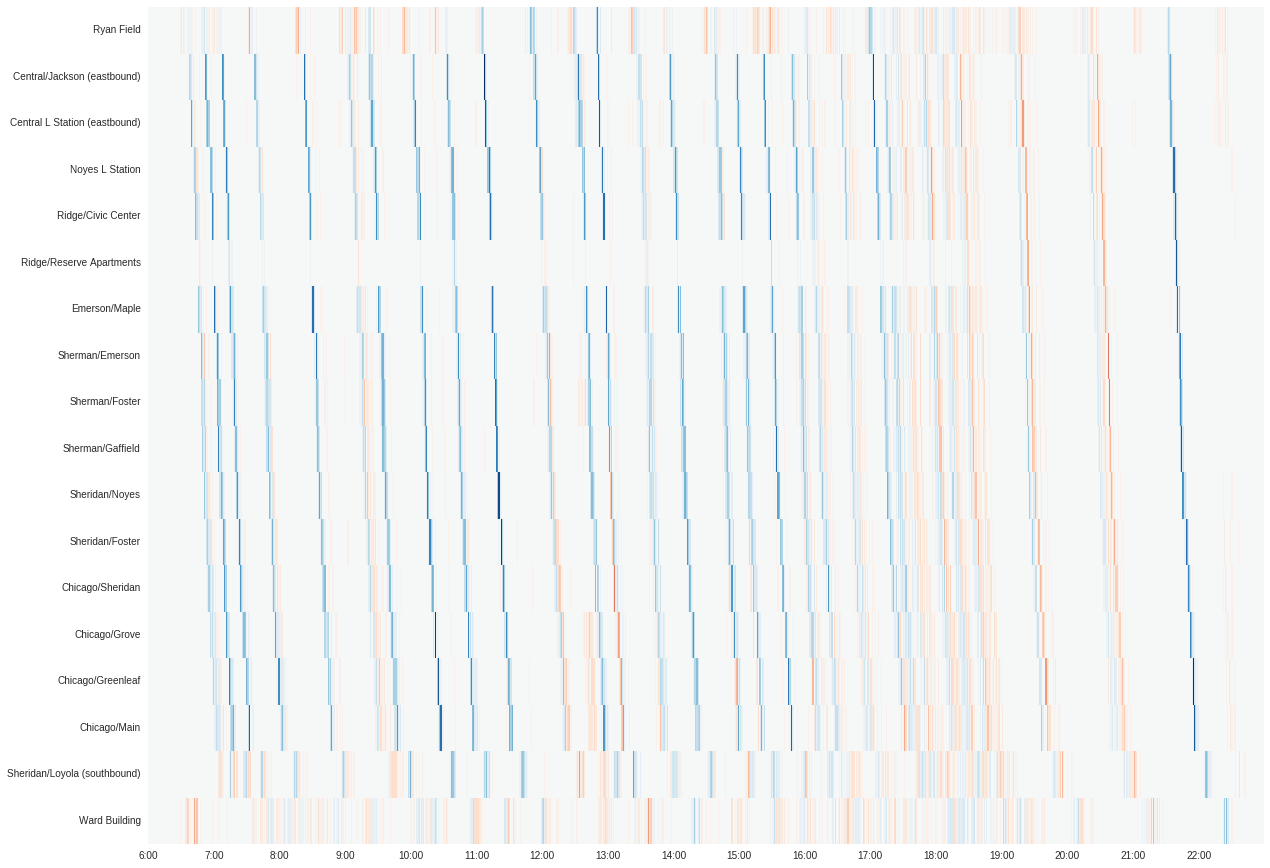

20.04005265235901 s to run


In [6]:
bus_heatmap(schedule, stop_data, start=6, end=23, window=5)

The above plot shows us, in blue, how frequently the shuttle arrives within five minutes of its scheduled arrival time, and in red, how frequently it misses its scheduled arrival time. Note the absence of stops at the Ridge/Reserve Apartments due to construction. For the most part, the shuttle is within the stated window, with the exception of the bus departing after 9am, 12pm, and during nearly the entirety of rush hour until 10pm.

Most importantly, the arrival time at Ward downtown appears to have a huge variance and is quite often later than the specified time. This is not unexpected because of traffic, but it is not clear from the shuttle schedule that these times are approximate. 

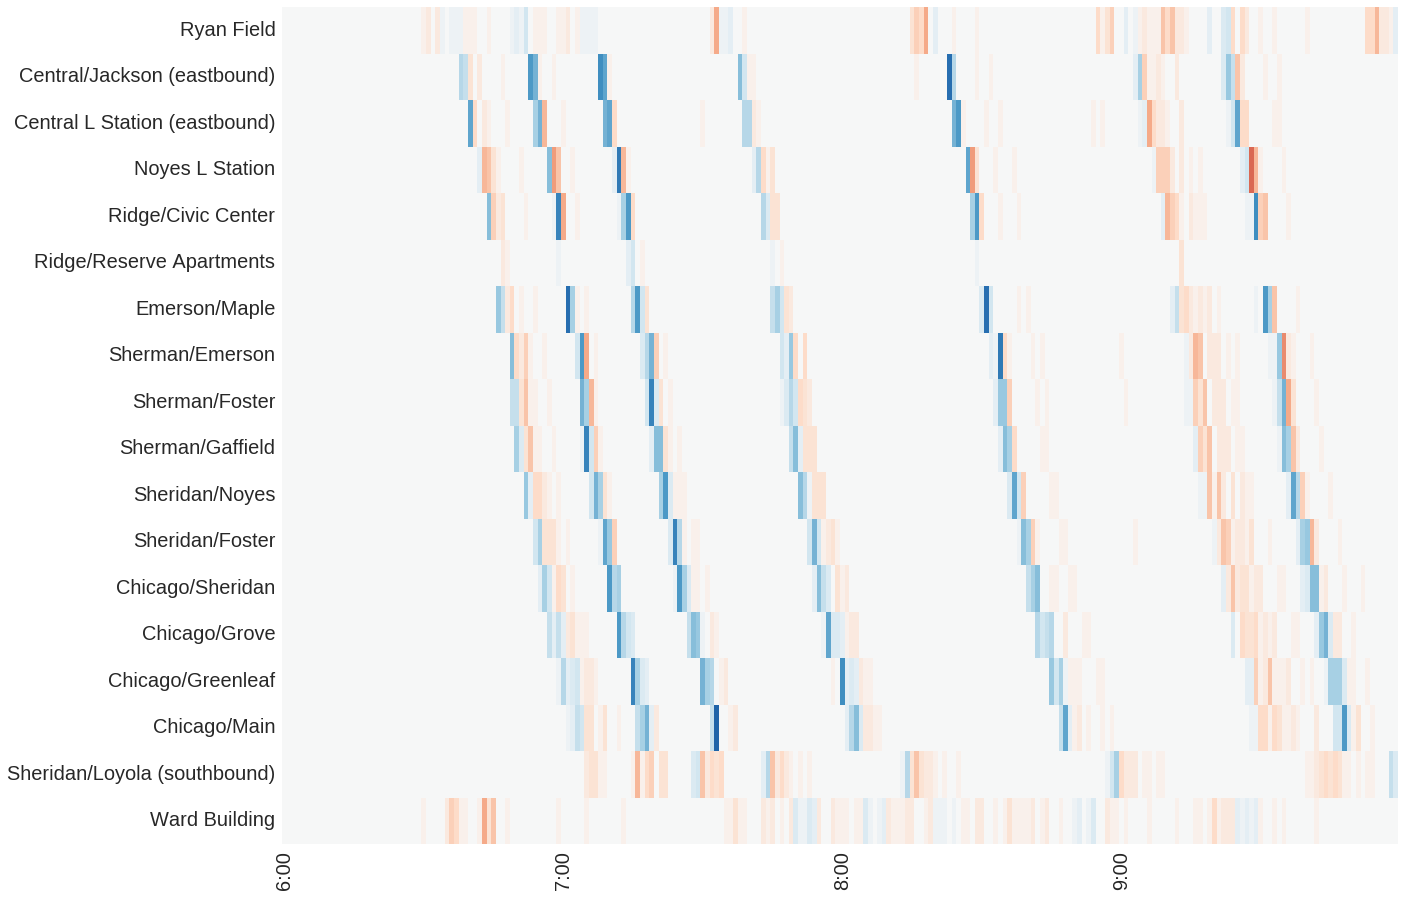

17.033926010131836 s to run


In [7]:
bus_heatmap(schedule, stop_data, start=6, end=10, window=3)

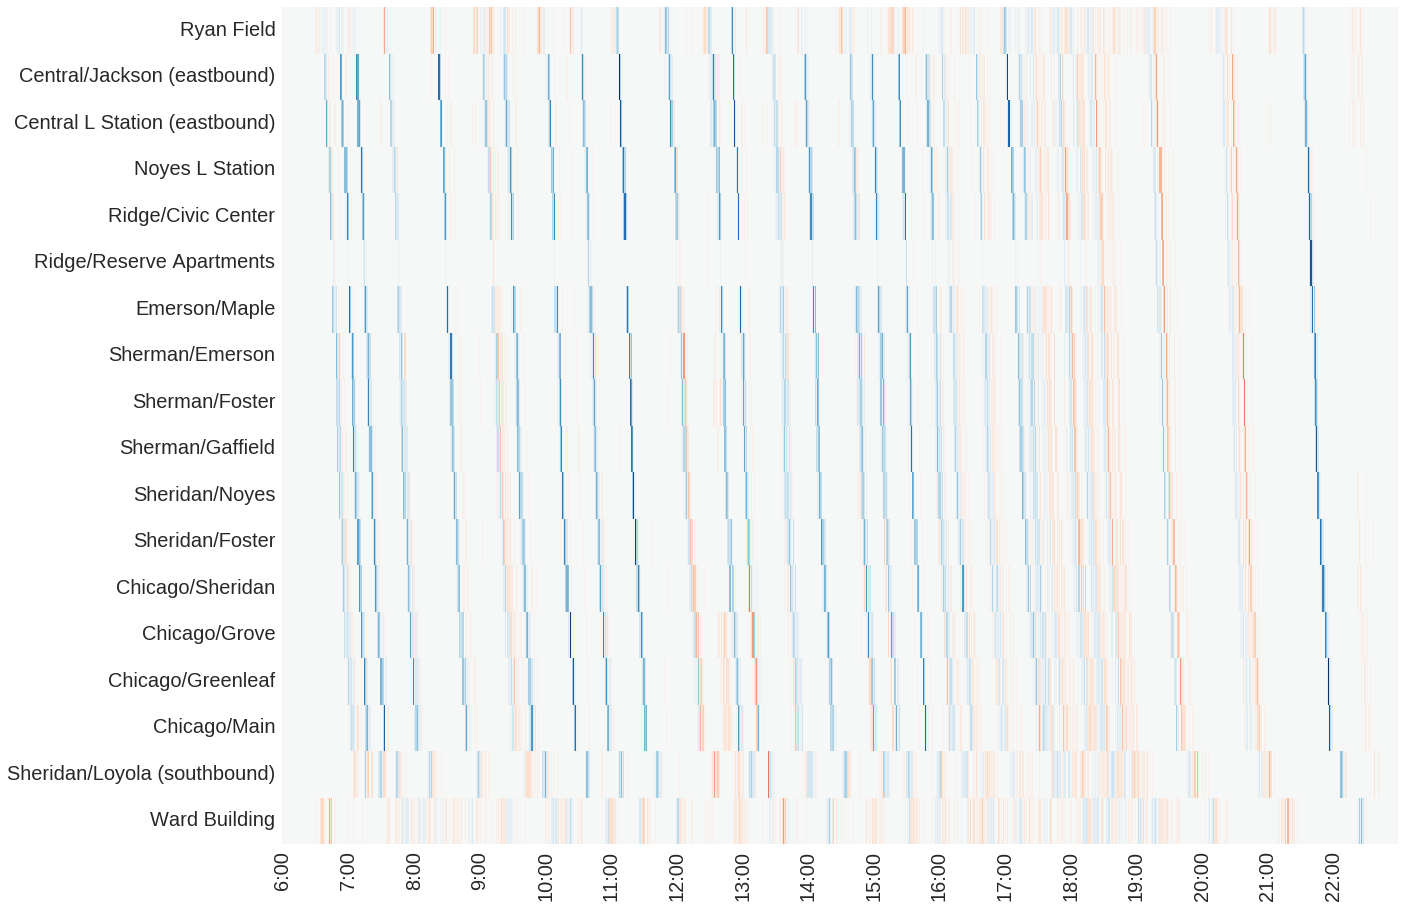

17.998117446899414 s to run


In [8]:
bus_heatmap(schedule, stop_data, window=5)

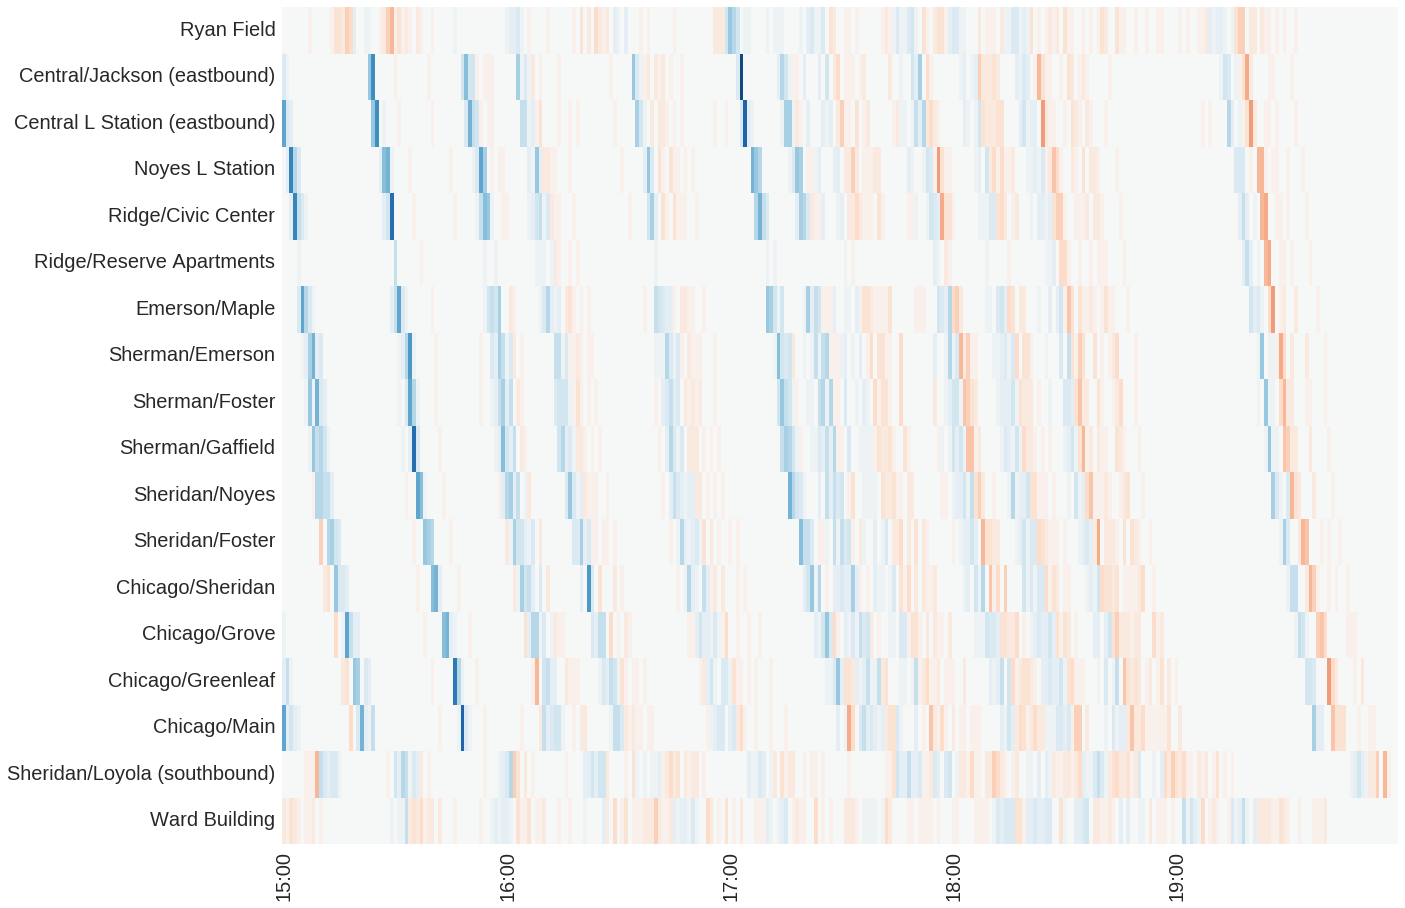

17.660747528076172 s to run


In [9]:
bus_heatmap(schedule, stop_data, start=15, end=20, window=5)

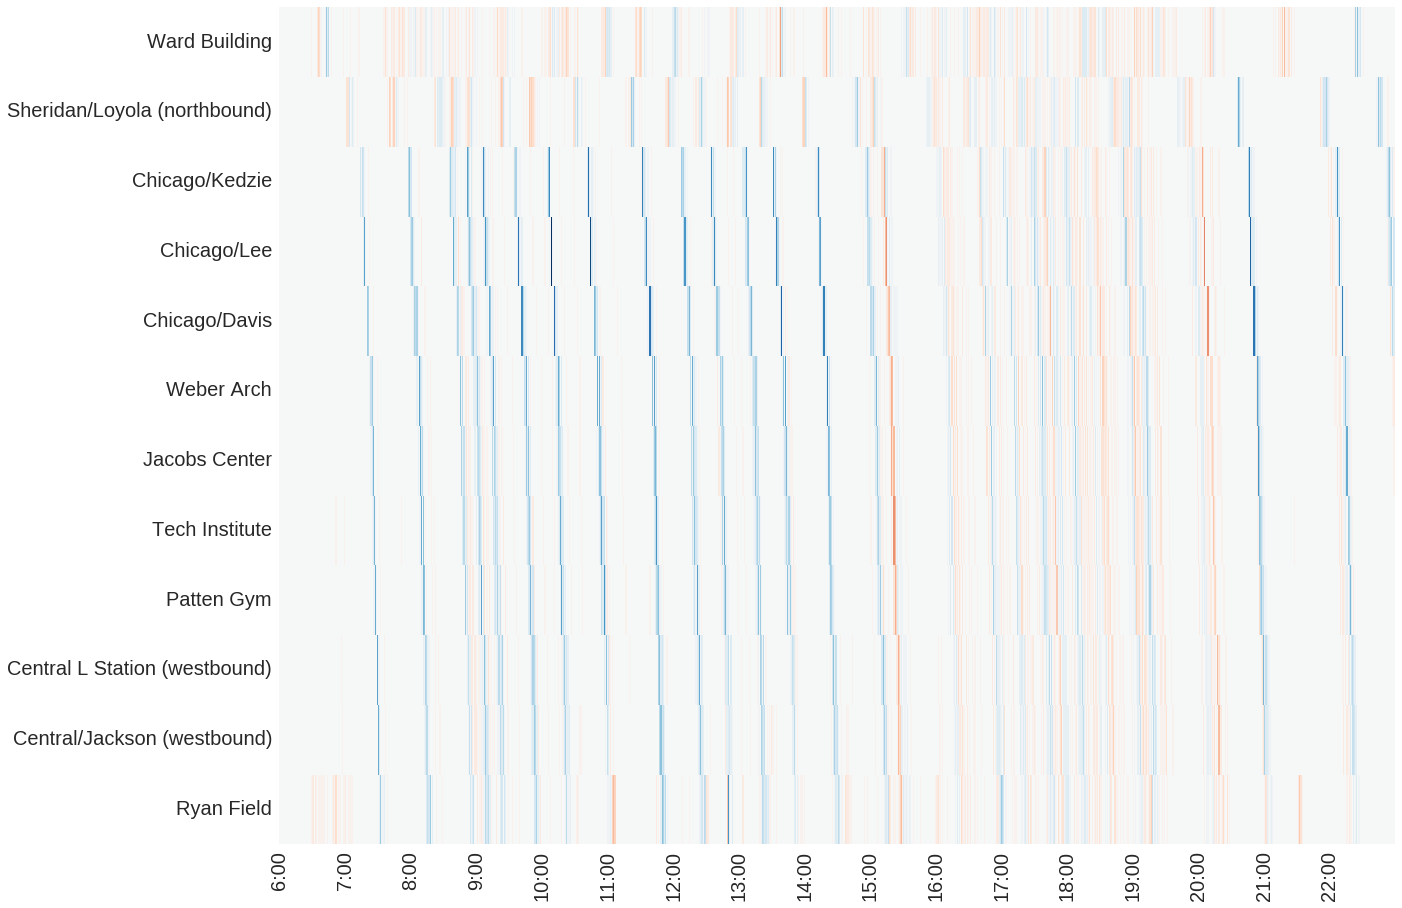

17.81665539741516 s to run


In [10]:
schedule = read_schedule('chicagotoevanston.csv')
bus_heatmap(schedule, stop_data, start=6, end=23, window=5)

On the reverse route, nearly all shuttles are on time until the afternoon, at which point everything goes crazy until the evening.

Future work: Can we use this data to determine performance of certain drivers (if they are on a regular schedule & the Bus ID corresponds to driver)